# Reward Training Analysis

In [34]:
import tdt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
# Get the root directory (adjust according to your folder structure)
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go up one directory to P2_Code
# Add the root directory to sys.path
sys.path.append(root_dir)

from group_tdt_class import *
from experiment_functions import *

In [35]:
experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Reward_Training\Day 1\mpfc"

# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Reward_Training\Day 10\mpfc"
brain_region = '#FFAF00'


# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Reward_Training\Day 1\nac"

# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Reward_Training\Day 10\nac"
# brain_region = '#15616F'

In [36]:
group_data = GroupTDTData(experiment_path, csv_base_path='None')

group_data.rt_processing()

Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Reward_Training\Day 1\mpfc\p1-240529-061914\Notes.txt
read from t=0s to t=1680.98s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Reward_Training\Day 1\mpfc\p2-240529-091204\Notes.txt
read from t=0s to t=1682.24s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Reward_Training\Day 1\mpfc\p3-240529-115040\Notes.txt
read from t=0s to t=1680.65s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Reward_Training\Day 1\mpfc\p4-240529-142834\Notes.txt
read from t=0s to t=1680.92s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Reward_Training\Day 1\mpfc\p5-240901-052302\Notes.txt
read from t=0s to t=1681.86s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Reward_Training\Day 1\mpfc\p6-240

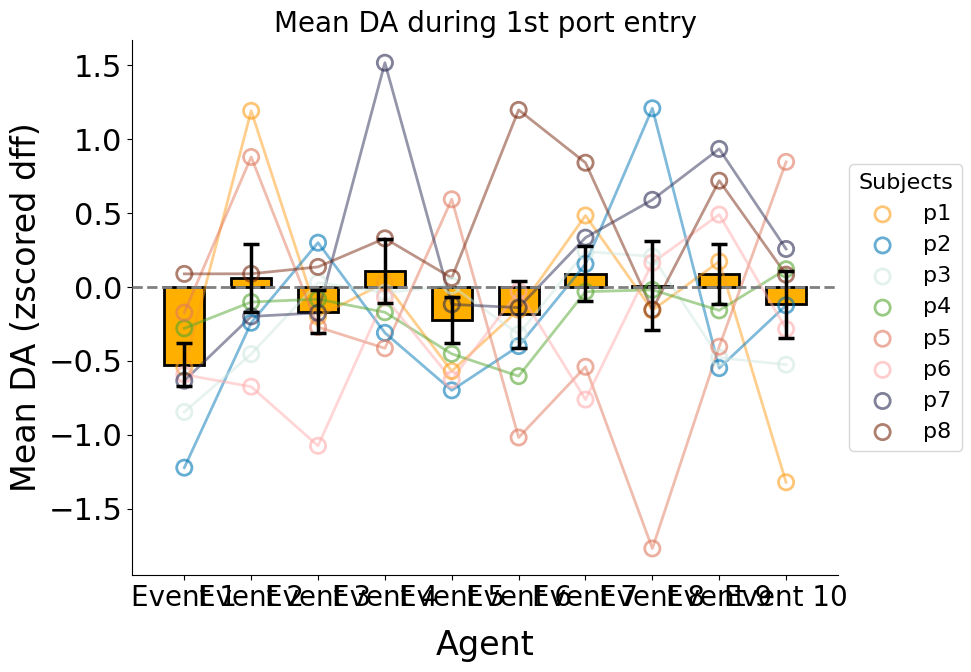

In [37]:
df = group_data.rt_extract_and_plot(n_entries=10, max_entries_per_sound_cue=3, behavior='sound cues')

plot_y_across_bouts(df, 'Mean DA during 1st port entry','Mean DA (zscored dff)',bar_color=brain_region)

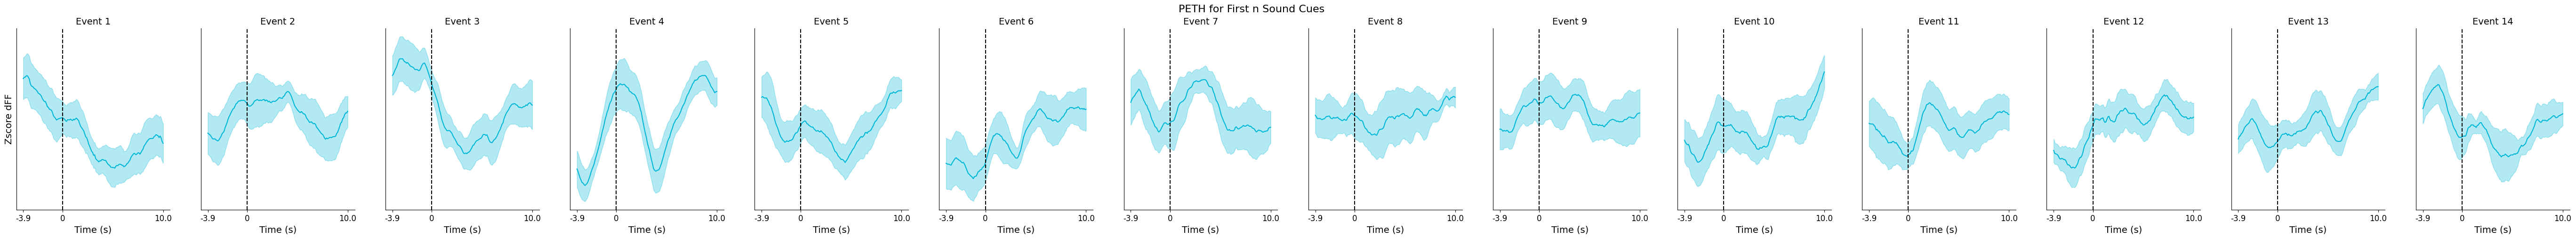

In [38]:
# Assuming 'group_data' is your GroupTDTData object

# Compute PETH around the first 5 sound cues
group_data.rt_compute_peth_per_event(behavior_name='sound cues', n_events=14, pre_time=100, post_time=10, bin_size=0.1)

# Plot the PETH
group_data.rt_plot_peth_per_event(signal_type='zscore', error_type='sem', title='PETH for First n Sound Cues',
                          color='#00B7D7', display_pre_time=4, display_post_time=10, yticks_interval=2)


Processing block: p1-240529-061914
Processing block: p2-240529-091204
Processing block: p3-240529-115040
Processing block: p4-240529-142834
Processing block: p5-240901-052302
Processing block: p6-240901-080800
Processing block: p7-240901-104150
Processing block: p8-240901-131350


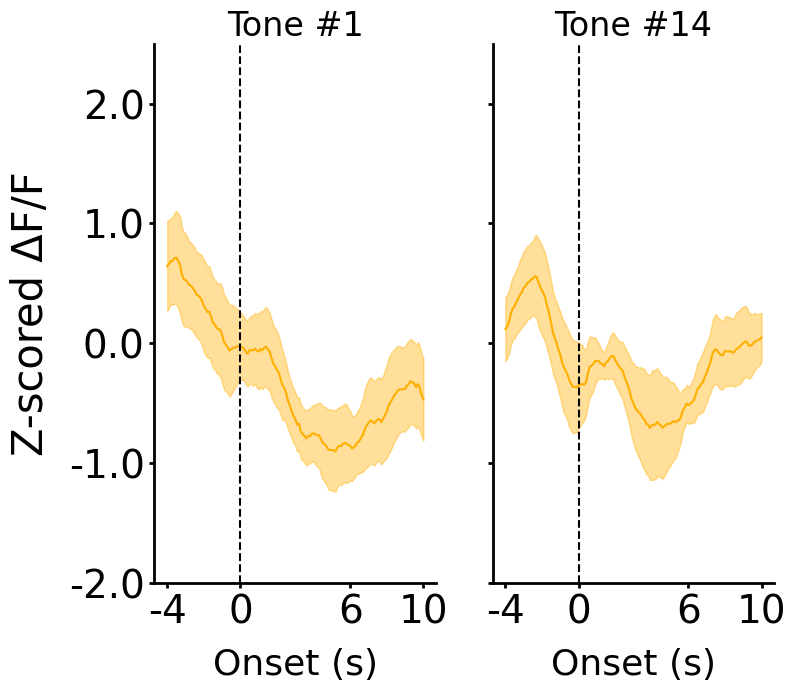

In [39]:
# Parameters
selected_indices = [1, 14]  # Specify which events to plot (1-based index)
event_type = 'sound cues'  # Choose between 'port entries' or 'sound cues'
pre_time = 4    # Time before event onset to include in PETH (seconds)
post_time = 10   # Time after event onset to include in PETH (seconds)
bin_size = 0.1  # Bin size for PETH (seconds)
y_axis_limits = (-1.5, 2.5)  # Set y-axis limits as a tuple (min, max). Set to None for auto-scaling.

# Initialize data structures
peri_event_signals = [[] for _ in selected_indices]  # List to collect signals for each selected event
common_time_axis = np.arange(-pre_time, post_time + bin_size, bin_size)

# Iterate over all blocks in group_data
for block_name, block_data in group_data.blocks.items():
    print(f"Processing block: {block_name}")

    # Extract event onsets based on the chosen event type
    event_onsets = np.array(block_data.behaviors[event_type].onset)
    
    # For each selected event
    for idx, event_index in enumerate(selected_indices):
        # Ensure the event_index is within the range of available events
        if event_index > len(event_onsets):
            print(f"Event index {event_index} exceeds the number of {event_type} in block {block_name}. Skipping.")
            continue
        
        # Get the onset of the specified event
        sc_onset = event_onsets[event_index - 1]  # 1-based index adjustment
        
        if event_type == 'port entries':
            # For port entries, find the first port entry after the sound cue onset
            pe_indices = np.where(block_data.behaviors['sound cues'].onset > sc_onset)[0]
            if len(pe_indices) == 0:
                print(f"No sound cues found after {event_type} at {sc_onset} seconds in block {block_name}.")
                continue
            sc_onset = block_data.behaviors['sound cues'].onset[pe_indices[0]]
        
        # Define time window around the event onset
        start_time = sc_onset - pre_time
        end_time = sc_onset + post_time
        
        # Get indices of DA signal within this window
        indices = np.where((block_data.timestamps >= start_time) & (block_data.timestamps <= end_time))[0]
        if len(indices) == 0:
            print(f"No DA data found for {event_type} at {sc_onset} seconds in block {block_name}.")
            continue
        
        # Extract DA signal and timestamps
        da_segment = block_data.zscore[indices]
        time_segment = block_data.timestamps[indices] - sc_onset  # Align time to event onset
        
        # Interpolate DA signal onto the common time axis
        interpolated_da = np.interp(common_time_axis, time_segment, da_segment)
        
        # Collect the interpolated DA signal
        peri_event_signals[idx].append(interpolated_da)

# Now, peri_event_signals is a list where each element is a list of DA signals from each block for that event

# Plot individual PETHs side by side for each selected event number
num_events = len(selected_indices)
fig, axes = plt.subplots(1, num_events, figsize=(4 * num_events, 7), sharey=True)
if num_events == 1:
    axes = [axes]  # Ensure axes is iterable

for i, ax in enumerate(axes):
    event_signals = peri_event_signals[i]
    if not event_signals:
        print(f"No data collected for {event_type} {i+1}.")
        continue
    # Convert to numpy array
    event_signals = np.array(event_signals)
    # Compute mean and SEM
    mean_peth = np.mean(event_signals, axis=0)
    sem_peth = np.std(event_signals, axis=0) / np.sqrt(len(event_signals))
    # Plot
    ax.plot(common_time_axis, mean_peth, color=brain_region, label='Mean DA')
    ax.fill_between(common_time_axis, mean_peth - sem_peth, mean_peth + sem_peth, color=brain_region, alpha=0.4)
    ax.axvline(0, color='black', linestyle='--')
    ax.set_title(f'Tone #{selected_indices[i]}', fontsize=24)
    ax.set_xlabel('Onset (s)', fontsize=26, labelpad=12)
    
    # Only show y-axis label and ticks on the first plot
    if i == 0:
        ax.set_ylabel('Z-scored ΔF/F', fontsize=30, labelpad= 12)
    else:
        ax.tick_params(axis='y', labelleft=False)  # Hide y-ticks on subsequent plots

    # Set x-ticks and labels, including 6 seconds
    ax.set_xticks([common_time_axis[0], 0, 6, common_time_axis[-1]])
    ax.set_xticklabels([f'{common_time_axis[0]:.1f}', '0', '6.0', f'{common_time_axis[-1]:.1f}'], fontsize=20)
    ax.set_xticklabels(['-4', '0','6', '10'], fontsize=24)
    
    # Apply the same y-axis limits across all plots and ensure 0 is included
    if y_axis_limits:
        ax.set_ylim(y_axis_limits)
    else:
        # Adjust to include 0 in y-axis range
        min_y = min(0, np.min(mean_peth - sem_peth))
        max_y = max(0, np.max(mean_peth + sem_peth))
        ax.set_ylim(min_y, max_y)

    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_yticklabels(['-2.0', '-1.0', '0.0', '1.0', '2.0'], fontsize=28)
    
    # Manually ensure 0 is included in y-ticks
    y_ticks = ax.get_yticks()
    if 0 not in y_ticks:
        y_ticks = np.append(y_ticks, 0)
    ax.set_yticks(y_ticks)
    ax.tick_params(axis='both', which='major', labelsize=28, width=2)  # Adjust tick label size and width

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # **Adjust spine linewidths to make axes lines thicker**
    ax.spines['left'].set_linewidth(2)    # Left axis line
    ax.spines['bottom'].set_linewidth(2)  # Bottom axis line

plt.savefig(f'PETH.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

# plt.suptitle(f'Mean PETH for Selected {event_type.capitalize()} Events', fontsize=16)
plt.show()

# # Compute overall mean PETH across all selected events
# all_event_signals = []
# for event_signals in peri_event_signals:
#     all_event_signals.extend(event_signals)  # Flatten the list

# if all_event_signals:
#     all_event_signals = np.array(all_event_signals)
#     mean_peth = np.mean(all_event_signals, axis=0)
#     sem_peth = np.std(all_event_signals, axis=0) / np.sqrt(len(all_event_signals))
    
#     # Plot the overall mean PETH
#     plt.figure(figsize=(10, 6))
#     plt.plot(common_time_axis, mean_peth, color=brain_region, label='Mean DA')
#     plt.fill_between(common_time_axis, mean_peth - sem_peth, mean_peth + sem_peth, color=brain_region, alpha=0.3)
#     plt.axvline(0, color='black', linestyle='--')
#     plt.xlabel('Time from Onset (s)', fontsize=20)
#     plt.ylabel('DA Signal (z-score)', fontsize=20)
#     if y_axis_limits:
#         plt.ylim(y_axis_limits)
#     else:
#         min_y = min(0, np.min(mean_peth - sem_peth))
#         max_y = max(0, np.max(mean_peth + sem_peth))
#         plt.ylim(min_y, max_y)
#     plt.xticks([common_time_axis[0], 0, 6, common_time_axis[-1]], [f'{common_time_axis[0]:.1f}', '0', '6.0', f'{common_time_axis[-1]:.1f}'], fontsize=16)
#     plt.title(f'Overall Mean PETH for Selected {event_type.capitalize()} Events', fontsize=16)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
# else:
#     print("No peri-event signals collected across all blocks.")


Processing block: p1-240529-061914
Processing block: p2-240529-091204
Processing block: p3-240529-115040
Processing block: p4-240529-142834
Processing block: p5-240901-052302
Processing block: p6-240901-080800
Processing block: p7-240901-104150
Processing block: p8-240901-131350


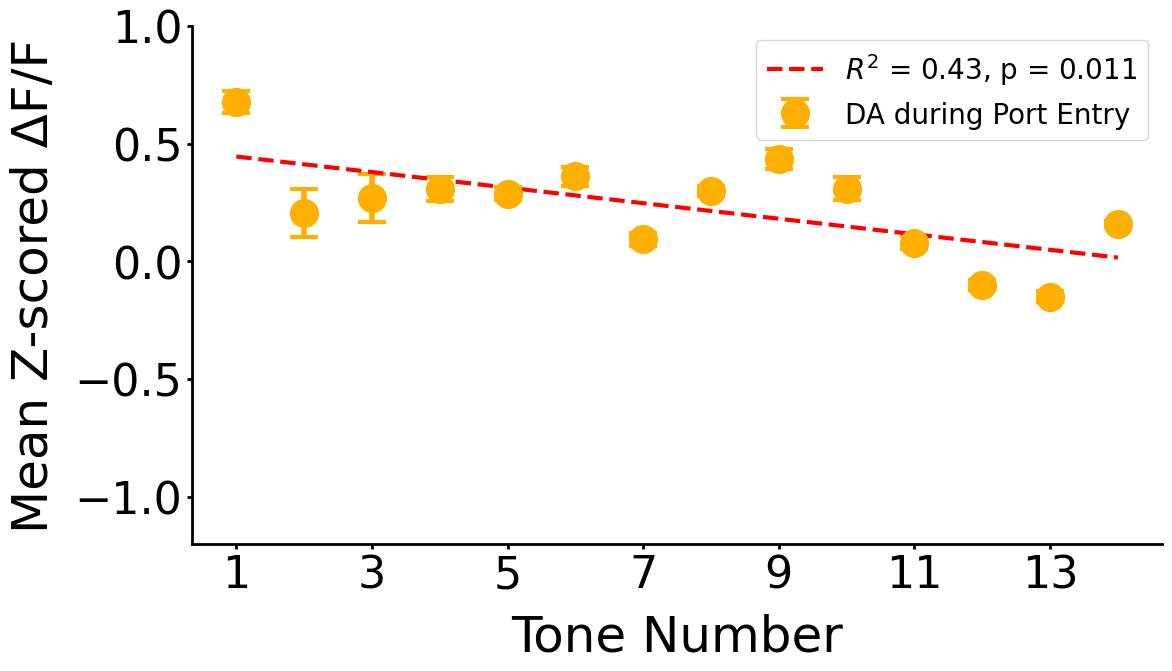

Slope: -0.0330, Intercept: 0.4781
Pearson correlation coefficient (R): -0.6539, p-value: 1.1189e-02


In [40]:

# Compute mean DA across trials
df_mean_da = compute_mean_da_across_trials(group_data, n=14, pre_time=4, post_time=4, bin_size=0.1, mean_window=2)

# Plot linear fit and compute correlation
slope, intercept, r_value, p_value = plot_linear_fit_with_error_bars(df_mean_da, color=brain_region, y_limits=(-1.2,1))

# # Compute mean DA across trials with SEM
# df_mean_da = compute_mean_da_across_trials(group_data, n=15, pre_time=5, post_time=5, bin_size=0.1, mean_window=4)

# # Plot linear fit with SEM error bars and compute correlation
# slope, intercept, r_value, p_value = plot_linear_fit_with_error_bars(df_mean_da)

Processing block: p1-240529-061914
Processing block: p2-240529-091204
Processing block: p3-240529-115040
Processing block: p4-240529-142834
Processing block: p5-240901-052302
Processing block: p6-240901-080800
Processing block: p7-240901-104150
Processing block: p8-240901-131350


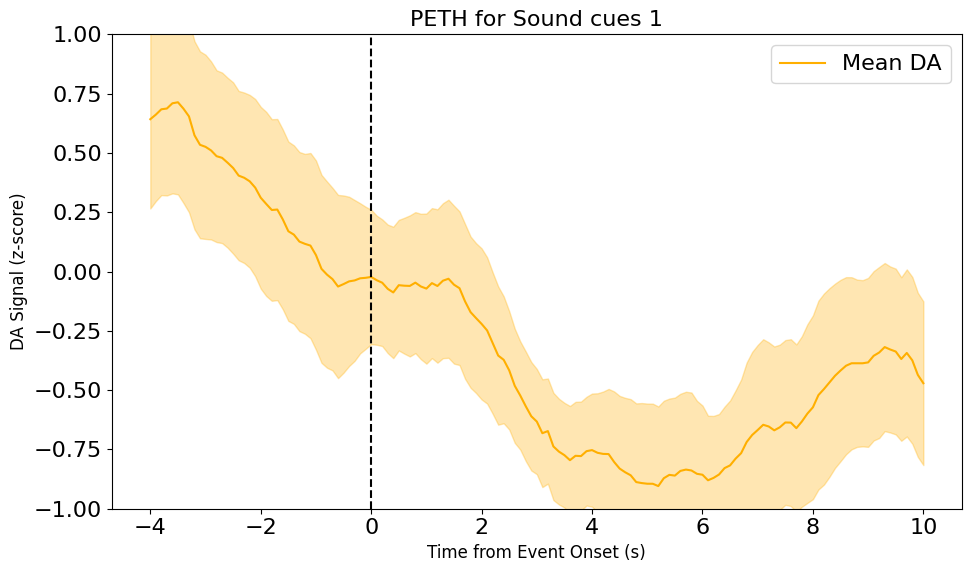

In [41]:
# Parameters
trial_number = 1  # Specify which trial to plot (1-based index)
event_type = 'sound cues'  # Choose between 'port entries' or 'sound cues'
pre_time = 4      # Time before event onset to include in PETH (seconds)
post_time = 10    # Time after event onset to include in PETH (seconds)
bin_size = 0.1    # Bin size for PETH (seconds)
y_axis_limits = (-1, 1)  # Optional: Set y-axis limits as a tuple (min, max). Set to None for auto-scaling.

# Initialize data structures
peri_event_signals = []  # List to collect signals for the specified trial
common_time_axis = np.arange(-pre_time, post_time + bin_size, bin_size)

# Iterate over all blocks in group_dataz
for block_name, block_data in group_data.blocks.items():
    print(f"Processing block: {block_name}")

    # Extract sound cue onsets and port entry onsets from the block
    event_onsets = np.array(block_data.behaviors[event_type].onset)
    
    # Ensure the trial_number is within the range of available events
    if trial_number > len(event_onsets):
        print(f"Trial number {trial_number} exceeds the number of {event_type} in block {block_name}. Skipping.")
        continue
    
    # Get the onset of the specified trial
    event_onset = event_onsets[trial_number - 1]  # 1-based index adjustment
    
    # For port entries, find the first port entry after the sound cue onset
    if event_type == 'port entries':
        sound_cue_onsets = np.array(block_data.behaviors['sound cues'].onset)
        pe_indices = np.where(sound_cue_onsets > event_onset)[0]
        if len(pe_indices) == 0:
            print(f"No sound cues found after {event_type} at {event_onset} seconds in block {block_name}.")
            continue
        first_pe_index = pe_indices[0]
        event_onset = sound_cue_onsets[first_pe_index]
    
    # Define time window around the event onset
    start_time = event_onset - pre_time
    end_time = event_onset + post_time
    
    # Get indices of DA signal within this window
    indices = np.where((block_data.timestamps >= start_time) & (block_data.timestamps <= end_time))[0]
    if len(indices) == 0:
        print(f"No DA data found for {event_type} at {event_onset} seconds in block {block_name}.")
        continue
    
    # Extract DA signal and timestamps
    da_segment = block_data.zscore[indices]
    time_segment = block_data.timestamps[indices] - event_onset  # Align time to event onset
    
    # Interpolate DA signal onto the common time axis
    interpolated_da = np.interp(common_time_axis, time_segment, da_segment)
    
    # Collect the interpolated DA signal
    peri_event_signals.append(interpolated_da)

# Plot the PETH for the specified trial
if peri_event_signals:
    # Convert to numpy array
    peri_event_signals = np.array(peri_event_signals)
    # Compute mean and SEM
    mean_peth = np.mean(peri_event_signals, axis=0)
    sem_peth = np.std(peri_event_signals, axis=0) / np.sqrt(len(peri_event_signals))
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(common_time_axis, mean_peth, color=brain_region, label='Mean DA')
    plt.fill_between(common_time_axis, mean_peth - sem_peth, mean_peth + sem_peth, color=brain_region, alpha=0.3)
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel('Time from Event Onset (s)', fontsize=12)
    plt.ylabel('DA Signal (z-score)', fontsize=12)
    plt.title(f'PETH for {event_type.capitalize()} {trial_number}', fontsize=16)
    if y_axis_limits:
        plt.ylim(y_axis_limits)  # Apply the y-axis limits if specified
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"No peri-event signals collected for trial {trial_number}.")


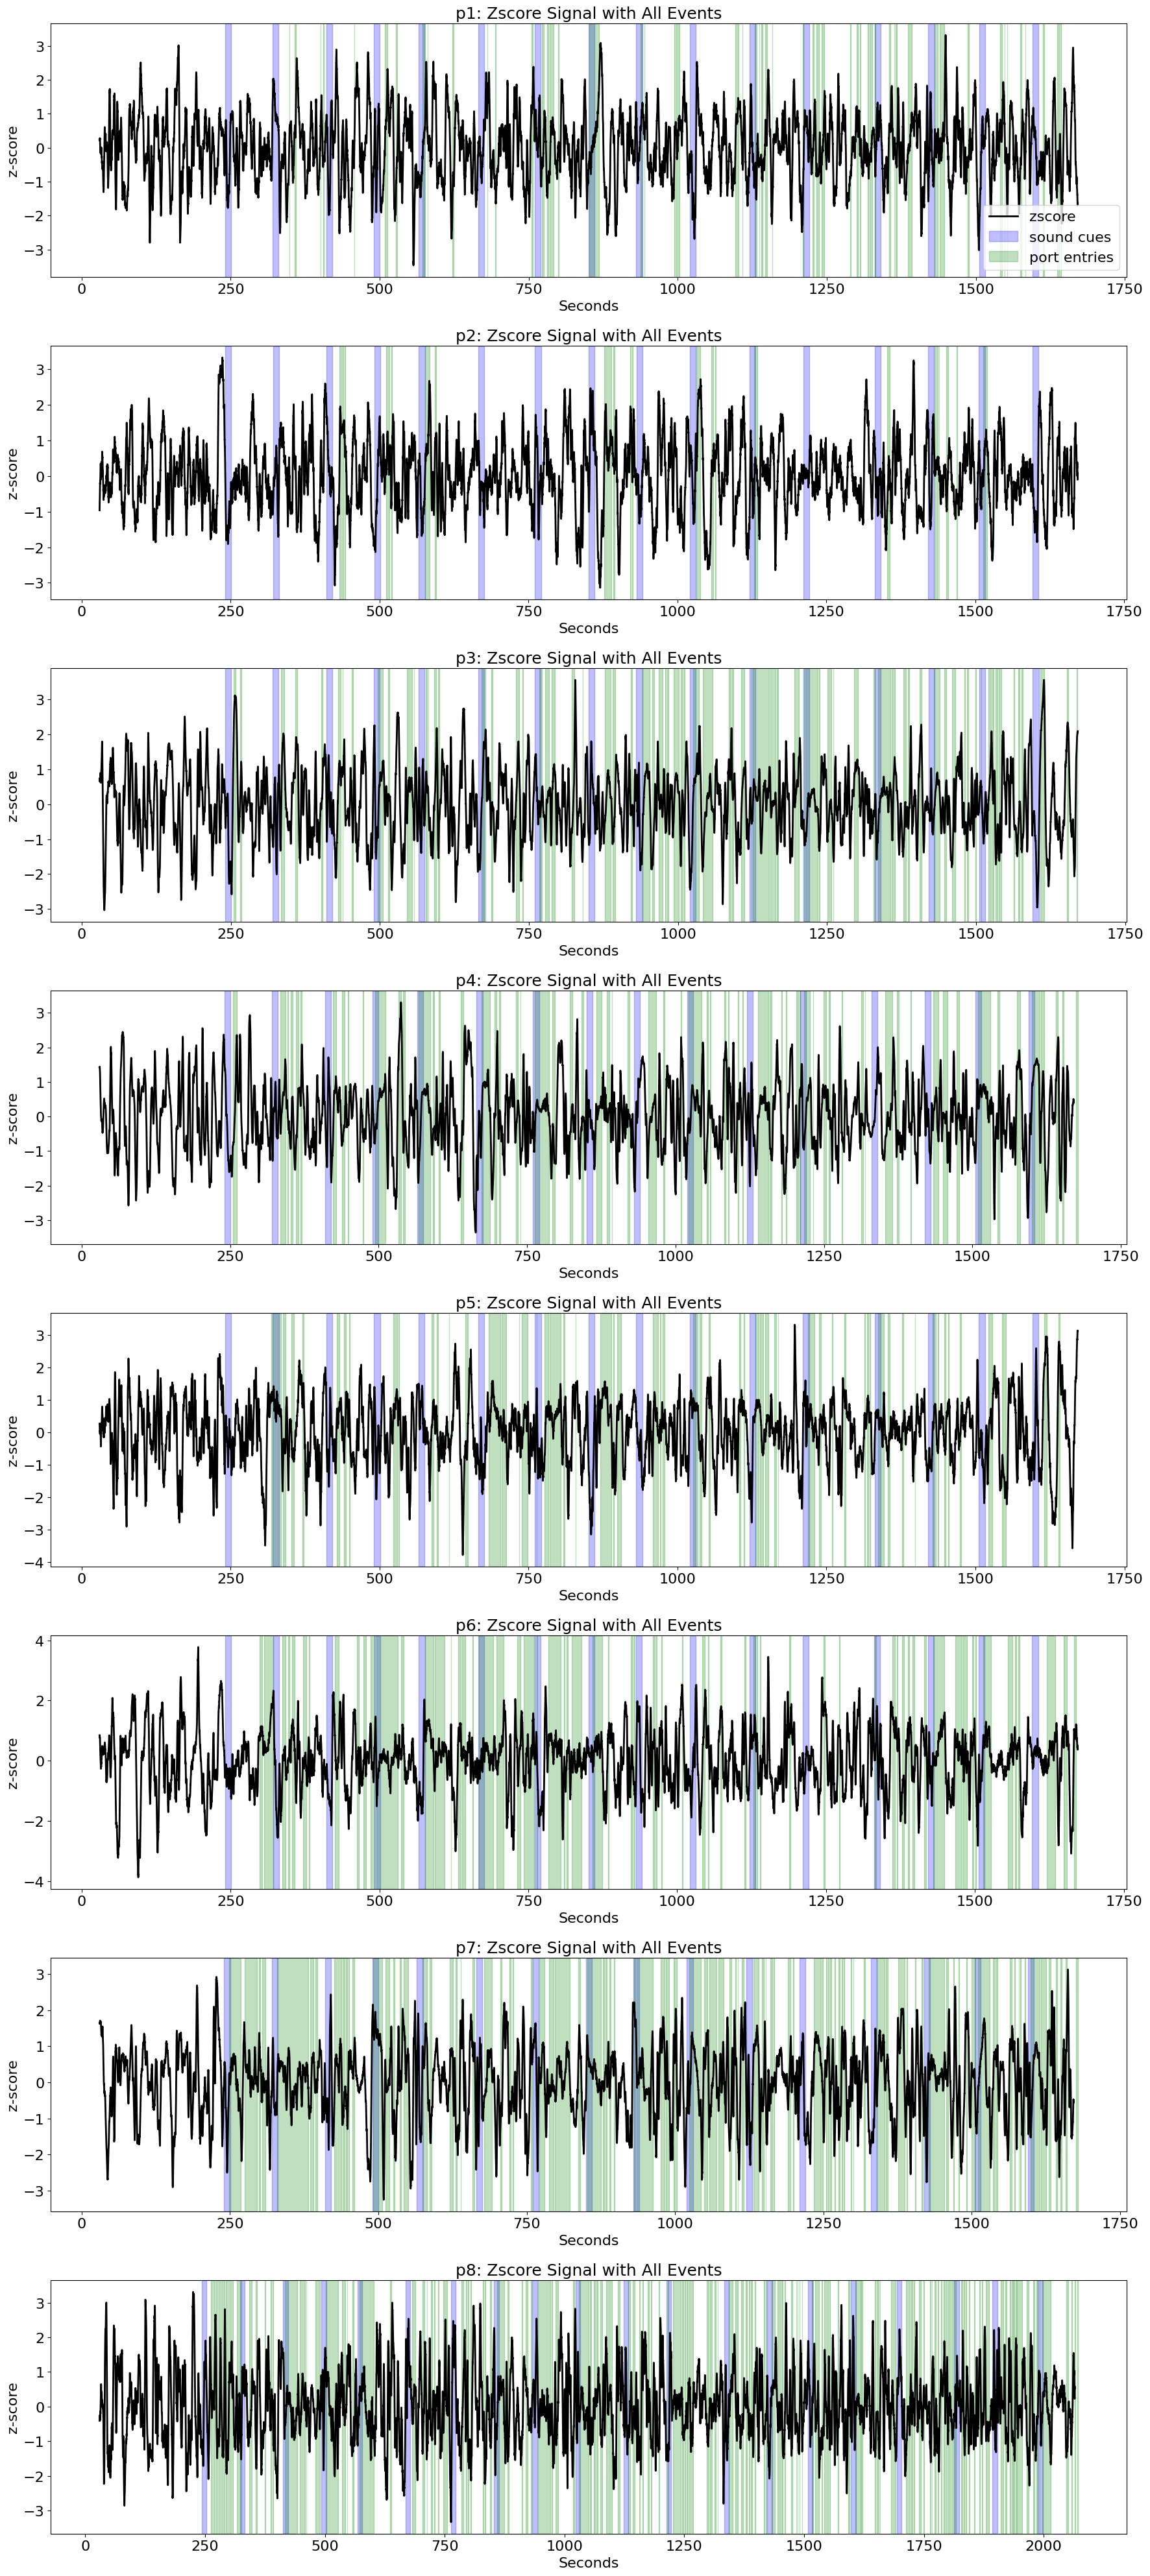

In [42]:
group_data.rt_plot_individual_behavior()